# Interpretability tutorial

In this tutorial we will go through several popular visualization techniques that help interpret deep learning networks.

We will cover:
1. Filter visualization
2. Feature/ activation visualization
3. CNN Layer Visualization
4. Gradient visualization with Guided backpropagation
5. Class Activation Maps
6. Deep dream

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np 
import visualizations
from visualizations.src.guided_backprop import GuidedBackprop
from visualizations.src.misc_functions import *
from visualizations.src.cnn_layer_visualization import CNNLayerVisualization
from visualizations.src.gradcam import GradCam
from visualizations.src.deep_dream import DeepDream
%matplotlib inline 

## 1. Filter Visualization

https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=uQI9jHcP6xfP

One of the first things you can visualize in your network - is your network filters, or weights.
Your convolutional kernels have weights which are updated during training, and can be visualized by calling the weight data inside your network.

Let's first load and print a pretrained network using pytorch.models:

In [5]:
# first load pretrained alxenet model
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see that the network is made up of two sequential models - features, and classifier.

To visualize the convolutional weights, we need to access a convolutional layer in the features model.

This can be done in the following way:
```python 
weight_tensor = model.features[layer_num].weight.data
```
**Note that layer_num should correspond to a convolutional layer - otherwise there are no weights to be visualized.**

We will now define a few functions to help with plotting:

In [6]:
def plot_filters_single_channel(t):
    
    kernels_to_plot = 30
    channels_to_plot = 3
    #kernels depth * number of kernels
    nplots = channels_to_plot*kernels_to_plot
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(kernels_to_plot):
        for j in range(channels_to_plot):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()    

    
def plot_filters_multi_channel(t):
    
    kernels_to_plot = 60
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = kernels_to_plot // num_cols
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(kernels_to_plot):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    


We next define our plot weights function, which first extracts the weights of a convolutional filter, and then passes into an appropriate image plotting function.

In [7]:
def plot_weights(model, layer_num, single_channel = True):
    #extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    #checking whether the layer is convolution layer or not 

    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data
    
        if single_channel:
            plot_filters_single_channel(weight_tensor)
        
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
        
    else:
        print("Can only visualize layers which are convolutional")
    

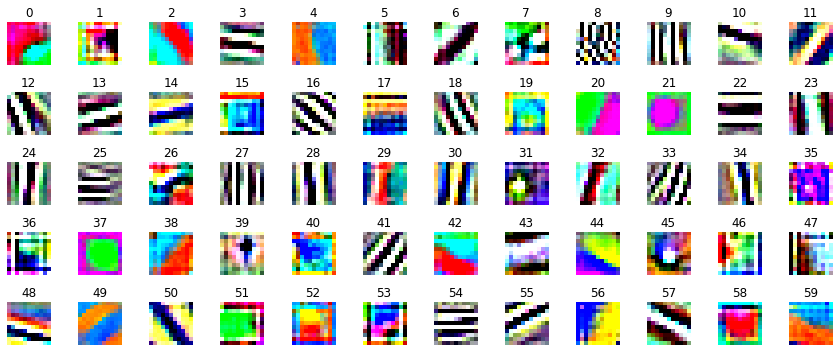

In [8]:
#visualize weights for alexnet - first conv layer
plot_weights(alexnet, 0, single_channel = False)


### Task 1: Visualize the filters of different convolutional layers

Use the plot_weights() function to visualize filters of different convolutional layers.

Note that you can plot single channels if you set single_channel=True (if the filters have 3 channels)


In [9]:
# --------------------------------------------- Task 1 --------------------------------------------------------
# write code here


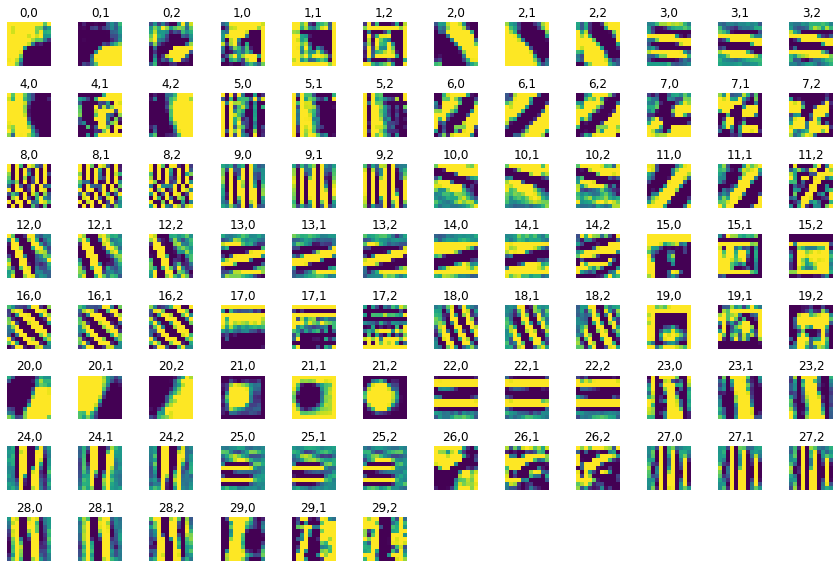

In [10]:
plot_weights(alexnet, 0, single_channel = True)

## 2. Activation visualization

Another effective approach to examine what your network is learning, is the visualize your network's features or activations, i.e. intermediate outputs of your network for a specific inputs.

In the following example, we set up a simple autoencoder network, a network that learns to reconstruct an input, using the MNIST dataset. 

https://discuss.pytorch.org/t/visualize-feature-map/29597/2

### Set up and train a simple autoencoder
We first set up the network, dataset (MNIST using torchvision), optimizer, and loss function. 

In [11]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

# normalisation - for plotting output
def min_max_norm(img):
    img = img - img.min()
    img = img / img.max()
    return img

dataset = datasets.MNIST(
    root="data",download=True,
    transform=transforms.ToTensor()
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

# initialize the network, loss function and optimizer 
model = SimpleAutoencoder()
criterion_l1 = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Train our simple network on MNIST

In [12]:
epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion_l1(output, data)
        loss.backward()
        optimizer.step()
        
        print('Epoch {}, Iteration {}, loss {}'.format(
            epoch, batch_idx, loss.item()))


Epoch 0, Iteration 0, loss 0.6832887530326843
Epoch 0, Iteration 1, loss 0.6835001111030579
Epoch 0, Iteration 2, loss 0.6812220811843872
Epoch 0, Iteration 3, loss 0.6808884143829346
Epoch 0, Iteration 4, loss 0.6815808415412903
Epoch 0, Iteration 5, loss 0.6800229549407959
Epoch 0, Iteration 6, loss 0.6790443658828735
Epoch 0, Iteration 7, loss 0.6776143908500671
Epoch 0, Iteration 8, loss 0.6771755814552307
Epoch 0, Iteration 9, loss 0.6767888069152832
Epoch 0, Iteration 10, loss 0.6764936447143555
Epoch 0, Iteration 11, loss 0.6757382750511169
Epoch 0, Iteration 12, loss 0.6753361225128174
Epoch 0, Iteration 13, loss 0.6743153929710388
Epoch 0, Iteration 14, loss 0.6723337769508362
Epoch 0, Iteration 15, loss 0.6724708080291748
Epoch 0, Iteration 16, loss 0.6712728142738342
Epoch 0, Iteration 17, loss 0.6711128354072571
Epoch 0, Iteration 18, loss 0.6707932353019714
Epoch 0, Iteration 19, loss 0.6716641783714294
Epoch 0, Iteration 20, loss 0.669347882270813
Epoch 0, Iteration 21, l

Epoch 0, Iteration 199, loss 0.33060166239738464
Epoch 0, Iteration 200, loss 0.3479156792163849
Epoch 0, Iteration 201, loss 0.36063435673713684
Epoch 0, Iteration 202, loss 0.2977968752384186
Epoch 0, Iteration 203, loss 0.33430472016334534
Epoch 0, Iteration 204, loss 0.3296765983104706
Epoch 0, Iteration 205, loss 0.31805530190467834
Epoch 0, Iteration 206, loss 0.30082643032073975
Epoch 0, Iteration 207, loss 0.2894970774650574
Epoch 0, Iteration 208, loss 0.33391228318214417
Epoch 0, Iteration 209, loss 0.30339282751083374
Epoch 0, Iteration 210, loss 0.3017879128456116
Epoch 0, Iteration 211, loss 0.2980855703353882
Epoch 0, Iteration 212, loss 0.28598350286483765
Epoch 0, Iteration 213, loss 0.31497958302497864
Epoch 0, Iteration 214, loss 0.2861863672733307
Epoch 0, Iteration 215, loss 0.2952588200569153
Epoch 0, Iteration 216, loss 0.29331669211387634
Epoch 0, Iteration 217, loss 0.30776405334472656
Epoch 0, Iteration 218, loss 0.2942938208580017
Epoch 0, Iteration 219, loss 

Epoch 0, Iteration 393, loss 0.1401754766702652
Epoch 0, Iteration 394, loss 0.183604896068573
Epoch 0, Iteration 395, loss 0.19185535609722137
Epoch 0, Iteration 396, loss 0.17676886916160583
Epoch 0, Iteration 397, loss 0.18562813103199005
Epoch 0, Iteration 398, loss 0.16920039057731628
Epoch 0, Iteration 399, loss 0.20262904465198517
Epoch 0, Iteration 400, loss 0.18827302753925323
Epoch 0, Iteration 401, loss 0.17776863276958466
Epoch 0, Iteration 402, loss 0.17631417512893677
Epoch 0, Iteration 403, loss 0.16922906041145325
Epoch 0, Iteration 404, loss 0.17148113250732422
Epoch 0, Iteration 405, loss 0.16651231050491333
Epoch 0, Iteration 406, loss 0.17605863511562347
Epoch 0, Iteration 407, loss 0.19151999056339264
Epoch 0, Iteration 408, loss 0.17720140516757965
Epoch 0, Iteration 409, loss 0.1899324506521225
Epoch 0, Iteration 410, loss 0.18014203011989594
Epoch 0, Iteration 411, loss 0.15846332907676697
Epoch 0, Iteration 412, loss 0.19259071350097656
Epoch 0, Iteration 413, 

Epoch 0, Iteration 576, loss 0.17616690695285797
Epoch 0, Iteration 577, loss 0.1689521223306656
Epoch 0, Iteration 578, loss 0.16625885665416718
Epoch 0, Iteration 579, loss 0.1593685746192932
Epoch 0, Iteration 580, loss 0.17670409381389618
Epoch 0, Iteration 581, loss 0.17675699293613434
Epoch 0, Iteration 582, loss 0.16760742664337158
Epoch 0, Iteration 583, loss 0.1594361811876297
Epoch 0, Iteration 584, loss 0.15782752633094788
Epoch 0, Iteration 585, loss 0.1744263917207718
Epoch 0, Iteration 586, loss 0.16132359206676483
Epoch 0, Iteration 587, loss 0.18912957608699799
Epoch 0, Iteration 588, loss 0.18519940972328186
Epoch 0, Iteration 589, loss 0.15472003817558289
Epoch 0, Iteration 590, loss 0.16643472015857697
Epoch 0, Iteration 591, loss 0.16052685678005219
Epoch 0, Iteration 592, loss 0.18366678059101105
Epoch 0, Iteration 593, loss 0.18410524725914001
Epoch 0, Iteration 594, loss 0.1937309205532074
Epoch 0, Iteration 595, loss 0.18582025170326233
Epoch 0, Iteration 596, l

Epoch 0, Iteration 766, loss 0.1478041559457779
Epoch 0, Iteration 767, loss 0.14518992602825165
Epoch 0, Iteration 768, loss 0.14104540646076202
Epoch 0, Iteration 769, loss 0.16973398625850677
Epoch 0, Iteration 770, loss 0.16359925270080566
Epoch 0, Iteration 771, loss 0.15899373590946198
Epoch 0, Iteration 772, loss 0.15390338003635406
Epoch 0, Iteration 773, loss 0.18203355371952057
Epoch 0, Iteration 774, loss 0.15047407150268555
Epoch 0, Iteration 775, loss 0.1535698026418686
Epoch 0, Iteration 776, loss 0.14679817855358124
Epoch 0, Iteration 777, loss 0.15311996638774872
Epoch 0, Iteration 778, loss 0.15891873836517334
Epoch 0, Iteration 779, loss 0.16739630699157715
Epoch 0, Iteration 780, loss 0.1556326001882553
Epoch 0, Iteration 781, loss 0.16811154782772064
Epoch 0, Iteration 782, loss 0.17776210606098175
Epoch 0, Iteration 783, loss 0.13749250769615173
Epoch 0, Iteration 784, loss 0.14830529689788818
Epoch 0, Iteration 785, loss 0.15958468616008759
Epoch 0, Iteration 786,

Epoch 0, Iteration 955, loss 0.15324115753173828
Epoch 0, Iteration 956, loss 0.1792447865009308
Epoch 0, Iteration 957, loss 0.14441129565238953
Epoch 0, Iteration 958, loss 0.14549465477466583
Epoch 0, Iteration 959, loss 0.1375102996826172
Epoch 0, Iteration 960, loss 0.11890267580747604
Epoch 0, Iteration 961, loss 0.1587745100259781
Epoch 0, Iteration 962, loss 0.11566162109375
Epoch 0, Iteration 963, loss 0.14602842926979065
Epoch 0, Iteration 964, loss 0.15780800580978394
Epoch 0, Iteration 965, loss 0.16999110579490662
Epoch 0, Iteration 966, loss 0.1464274674654007
Epoch 0, Iteration 967, loss 0.13363337516784668
Epoch 0, Iteration 968, loss 0.14679521322250366
Epoch 0, Iteration 969, loss 0.14724712073802948
Epoch 0, Iteration 970, loss 0.1651826798915863
Epoch 0, Iteration 971, loss 0.15982097387313843
Epoch 0, Iteration 972, loss 0.1332983374595642
Epoch 0, Iteration 973, loss 0.14927607774734497
Epoch 0, Iteration 974, loss 0.12295272201299667
Epoch 0, Iteration 975, loss 

Epoch 0, Iteration 1163, loss 0.13344083726406097
Epoch 0, Iteration 1164, loss 0.13048593699932098
Epoch 0, Iteration 1165, loss 0.13913573324680328
Epoch 0, Iteration 1166, loss 0.14047351479530334
Epoch 0, Iteration 1167, loss 0.122547946870327
Epoch 0, Iteration 1168, loss 0.13901445269584656
Epoch 0, Iteration 1169, loss 0.1384264975786209
Epoch 0, Iteration 1170, loss 0.15153372287750244
Epoch 0, Iteration 1171, loss 0.14435310661792755
Epoch 0, Iteration 1172, loss 0.15528292953968048
Epoch 0, Iteration 1173, loss 0.11477524787187576
Epoch 0, Iteration 1174, loss 0.11848805844783783
Epoch 0, Iteration 1175, loss 0.12887220084667206
Epoch 0, Iteration 1176, loss 0.13945701718330383
Epoch 0, Iteration 1177, loss 0.15086299180984497
Epoch 0, Iteration 1178, loss 0.14218637347221375
Epoch 0, Iteration 1179, loss 0.1366184651851654
Epoch 0, Iteration 1180, loss 0.13885612785816193
Epoch 0, Iteration 1181, loss 0.1181359812617302
Epoch 0, Iteration 1182, loss 0.14921599626541138
Epoch

Epoch 0, Iteration 1369, loss 0.12947510182857513
Epoch 0, Iteration 1370, loss 0.13032323122024536
Epoch 0, Iteration 1371, loss 0.10520786046981812
Epoch 0, Iteration 1372, loss 0.12372536212205887
Epoch 0, Iteration 1373, loss 0.12719090282917023
Epoch 0, Iteration 1374, loss 0.12312856316566467
Epoch 0, Iteration 1375, loss 0.12595520913600922
Epoch 0, Iteration 1376, loss 0.12492096424102783
Epoch 0, Iteration 1377, loss 0.11702226847410202
Epoch 0, Iteration 1378, loss 0.14584708213806152
Epoch 0, Iteration 1379, loss 0.1387714296579361
Epoch 0, Iteration 1380, loss 0.11285465955734253
Epoch 0, Iteration 1381, loss 0.11719194054603577
Epoch 0, Iteration 1382, loss 0.1050063967704773
Epoch 0, Iteration 1383, loss 0.1284499615430832
Epoch 0, Iteration 1384, loss 0.1244945153594017
Epoch 0, Iteration 1385, loss 0.13163423538208008
Epoch 0, Iteration 1386, loss 0.1546921581029892
Epoch 0, Iteration 1387, loss 0.13124078512191772
Epoch 0, Iteration 1388, loss 0.14332693815231323
Epoch

Epoch 0, Iteration 1575, loss 0.10759789496660233
Epoch 0, Iteration 1576, loss 0.13446645438671112
Epoch 0, Iteration 1577, loss 0.11813326925039291
Epoch 0, Iteration 1578, loss 0.13998372852802277
Epoch 0, Iteration 1579, loss 0.10124801844358444
Epoch 0, Iteration 1580, loss 0.12888292968273163
Epoch 0, Iteration 1581, loss 0.12023544311523438
Epoch 0, Iteration 1582, loss 0.12876777350902557
Epoch 0, Iteration 1583, loss 0.10598449409008026
Epoch 0, Iteration 1584, loss 0.1243404671549797
Epoch 0, Iteration 1585, loss 0.11582853645086288
Epoch 0, Iteration 1586, loss 0.13167014718055725
Epoch 0, Iteration 1587, loss 0.1021927148103714
Epoch 0, Iteration 1588, loss 0.11908382177352905
Epoch 0, Iteration 1589, loss 0.11596568673849106
Epoch 0, Iteration 1590, loss 0.12332487851381302
Epoch 0, Iteration 1591, loss 0.11878360062837601
Epoch 0, Iteration 1592, loss 0.10812778770923615
Epoch 0, Iteration 1593, loss 0.12092170119285583
Epoch 0, Iteration 1594, loss 0.13505782186985016
Ep

Epoch 0, Iteration 1782, loss 0.1105329766869545
Epoch 0, Iteration 1783, loss 0.11363516002893448
Epoch 0, Iteration 1784, loss 0.11613770574331284
Epoch 0, Iteration 1785, loss 0.11785701662302017
Epoch 0, Iteration 1786, loss 0.1053277924656868
Epoch 0, Iteration 1787, loss 0.10904397070407867
Epoch 0, Iteration 1788, loss 0.10641946643590927
Epoch 0, Iteration 1789, loss 0.14310728013515472
Epoch 0, Iteration 1790, loss 0.09803933650255203
Epoch 0, Iteration 1791, loss 0.11770594120025635
Epoch 0, Iteration 1792, loss 0.10471096634864807
Epoch 0, Iteration 1793, loss 0.11186430603265762
Epoch 0, Iteration 1794, loss 0.10420766472816467
Epoch 0, Iteration 1795, loss 0.0971958115696907
Epoch 0, Iteration 1796, loss 0.10606397688388824
Epoch 0, Iteration 1797, loss 0.11327962577342987
Epoch 0, Iteration 1798, loss 0.12925824522972107
Epoch 0, Iteration 1799, loss 0.10124891996383667
Epoch 0, Iteration 1800, loss 0.10909576714038849
Epoch 0, Iteration 1801, loss 0.11308258771896362
Epo

Epoch 0, Iteration 1988, loss 0.10166140645742416
Epoch 0, Iteration 1989, loss 0.1010797843337059
Epoch 0, Iteration 1990, loss 0.11046317219734192
Epoch 0, Iteration 1991, loss 0.09811095148324966
Epoch 0, Iteration 1992, loss 0.12108689546585083
Epoch 0, Iteration 1993, loss 0.09883111715316772
Epoch 0, Iteration 1994, loss 0.09558624029159546
Epoch 0, Iteration 1995, loss 0.09179588407278061
Epoch 0, Iteration 1996, loss 0.1016584038734436
Epoch 0, Iteration 1997, loss 0.09349954128265381
Epoch 0, Iteration 1998, loss 0.10158026963472366
Epoch 0, Iteration 1999, loss 0.08816546946763992
Epoch 0, Iteration 2000, loss 0.10818357765674591
Epoch 0, Iteration 2001, loss 0.09645570814609528
Epoch 0, Iteration 2002, loss 0.12595337629318237
Epoch 0, Iteration 2003, loss 0.11517190933227539
Epoch 0, Iteration 2004, loss 0.10954981297254562
Epoch 0, Iteration 2005, loss 0.1014987975358963
Epoch 0, Iteration 2006, loss 0.10957550257444382
Epoch 0, Iteration 2007, loss 0.10202939063310623
Epo

Epoch 0, Iteration 2197, loss 0.10140300542116165
Epoch 0, Iteration 2198, loss 0.11721479892730713
Epoch 0, Iteration 2199, loss 0.11474423855543137
Epoch 0, Iteration 2200, loss 0.10189370065927505
Epoch 0, Iteration 2201, loss 0.09382670372724533
Epoch 0, Iteration 2202, loss 0.10884265601634979
Epoch 0, Iteration 2203, loss 0.0972587987780571
Epoch 0, Iteration 2204, loss 0.09969664365053177
Epoch 0, Iteration 2205, loss 0.11701523512601852
Epoch 0, Iteration 2206, loss 0.08695684373378754
Epoch 0, Iteration 2207, loss 0.10533680021762848
Epoch 0, Iteration 2208, loss 0.09133188426494598
Epoch 0, Iteration 2209, loss 0.11986223608255386
Epoch 0, Iteration 2210, loss 0.11345783621072769
Epoch 0, Iteration 2211, loss 0.09302211552858353
Epoch 0, Iteration 2212, loss 0.09722723066806793
Epoch 0, Iteration 2213, loss 0.10732033848762512
Epoch 0, Iteration 2214, loss 0.08826980739831924
Epoch 0, Iteration 2215, loss 0.09467251598834991
Epoch 0, Iteration 2216, loss 0.11720602959394455
E

Epoch 0, Iteration 2409, loss 0.09206219762563705
Epoch 0, Iteration 2410, loss 0.1188708022236824
Epoch 0, Iteration 2411, loss 0.0967261865735054
Epoch 0, Iteration 2412, loss 0.10307109355926514
Epoch 0, Iteration 2413, loss 0.08454406261444092
Epoch 0, Iteration 2414, loss 0.10823087394237518
Epoch 0, Iteration 2415, loss 0.08590561151504517
Epoch 0, Iteration 2416, loss 0.08650882542133331
Epoch 0, Iteration 2417, loss 0.10772613435983658
Epoch 0, Iteration 2418, loss 0.09585633873939514
Epoch 0, Iteration 2419, loss 0.10147644579410553
Epoch 0, Iteration 2420, loss 0.09962177276611328
Epoch 0, Iteration 2421, loss 0.09348156303167343
Epoch 0, Iteration 2422, loss 0.106325663626194
Epoch 0, Iteration 2423, loss 0.08881957828998566
Epoch 0, Iteration 2424, loss 0.09352836012840271
Epoch 0, Iteration 2425, loss 0.08971572667360306
Epoch 0, Iteration 2426, loss 0.09030929207801819
Epoch 0, Iteration 2427, loss 0.0887608528137207
Epoch 0, Iteration 2428, loss 0.0916789174079895
Epoch 

Epoch 0, Iteration 2598, loss 0.11693207919597626
Epoch 0, Iteration 2599, loss 0.0947149246931076
Epoch 0, Iteration 2600, loss 0.08989996463060379
Epoch 0, Iteration 2601, loss 0.09295917302370071
Epoch 0, Iteration 2602, loss 0.10923098772764206
Epoch 0, Iteration 2603, loss 0.07219549268484116
Epoch 0, Iteration 2604, loss 0.10007225722074509
Epoch 0, Iteration 2605, loss 0.10675769299268723
Epoch 0, Iteration 2606, loss 0.11069170385599136
Epoch 0, Iteration 2607, loss 0.09145516157150269
Epoch 0, Iteration 2608, loss 0.10996754467487335
Epoch 0, Iteration 2609, loss 0.09627865999937057
Epoch 0, Iteration 2610, loss 0.09473568946123123
Epoch 0, Iteration 2611, loss 0.11244519054889679
Epoch 0, Iteration 2612, loss 0.09296012669801712
Epoch 0, Iteration 2613, loss 0.10033633559942245
Epoch 0, Iteration 2614, loss 0.09319458156824112
Epoch 0, Iteration 2615, loss 0.11839573085308075
Epoch 0, Iteration 2616, loss 0.10108070075511932
Epoch 0, Iteration 2617, loss 0.10951682180166245
E

Epoch 0, Iteration 2777, loss 0.0914401113986969
Epoch 0, Iteration 2778, loss 0.08890972286462784
Epoch 0, Iteration 2779, loss 0.10959551483392715
Epoch 0, Iteration 2780, loss 0.10507147014141083
Epoch 0, Iteration 2781, loss 0.10697243362665176
Epoch 0, Iteration 2782, loss 0.09568370133638382
Epoch 0, Iteration 2783, loss 0.08920813351869583
Epoch 0, Iteration 2784, loss 0.10604401677846909
Epoch 0, Iteration 2785, loss 0.10384677350521088
Epoch 0, Iteration 2786, loss 0.09923893958330154
Epoch 0, Iteration 2787, loss 0.0981011688709259
Epoch 0, Iteration 2788, loss 0.10120667517185211
Epoch 0, Iteration 2789, loss 0.09436009079217911
Epoch 0, Iteration 2790, loss 0.07840211689472198
Epoch 0, Iteration 2791, loss 0.07983096688985825
Epoch 0, Iteration 2792, loss 0.08434426784515381
Epoch 0, Iteration 2793, loss 0.09443587064743042
Epoch 0, Iteration 2794, loss 0.08626975119113922
Epoch 0, Iteration 2795, loss 0.10284315049648285
Epoch 0, Iteration 2796, loss 0.09076923877000809
Ep

Epoch 0, Iteration 2966, loss 0.0982968658208847
Epoch 0, Iteration 2967, loss 0.08373256772756577
Epoch 0, Iteration 2968, loss 0.09524098038673401
Epoch 0, Iteration 2969, loss 0.08304823935031891
Epoch 0, Iteration 2970, loss 0.1009240671992302
Epoch 0, Iteration 2971, loss 0.09240560233592987
Epoch 0, Iteration 2972, loss 0.08208777010440826
Epoch 0, Iteration 2973, loss 0.10520851612091064
Epoch 0, Iteration 2974, loss 0.0972537249326706
Epoch 0, Iteration 2975, loss 0.09241018444299698
Epoch 0, Iteration 2976, loss 0.10498857498168945
Epoch 0, Iteration 2977, loss 0.08537661284208298
Epoch 0, Iteration 2978, loss 0.09657160937786102
Epoch 0, Iteration 2979, loss 0.08907265216112137
Epoch 0, Iteration 2980, loss 0.08853614330291748
Epoch 0, Iteration 2981, loss 0.11282341927289963
Epoch 0, Iteration 2982, loss 0.09815997630357742
Epoch 0, Iteration 2983, loss 0.09120208024978638
Epoch 0, Iteration 2984, loss 0.08885306119918823
Epoch 0, Iteration 2985, loss 0.09810159355401993
Epo

Epoch 0, Iteration 3161, loss 0.08983835577964783
Epoch 0, Iteration 3162, loss 0.09003838896751404
Epoch 0, Iteration 3163, loss 0.09817343205213547
Epoch 0, Iteration 3164, loss 0.0787864625453949
Epoch 0, Iteration 3165, loss 0.09241514652967453
Epoch 0, Iteration 3166, loss 0.09940385818481445
Epoch 0, Iteration 3167, loss 0.1017119511961937
Epoch 0, Iteration 3168, loss 0.09764126688241959
Epoch 0, Iteration 3169, loss 0.10039937496185303
Epoch 0, Iteration 3170, loss 0.0819171592593193
Epoch 0, Iteration 3171, loss 0.09841110557317734
Epoch 0, Iteration 3172, loss 0.08653326332569122
Epoch 0, Iteration 3173, loss 0.09548568725585938
Epoch 0, Iteration 3174, loss 0.09500998258590698
Epoch 0, Iteration 3175, loss 0.1017984002828598
Epoch 0, Iteration 3176, loss 0.08830472081899643
Epoch 0, Iteration 3177, loss 0.09194029867649078
Epoch 0, Iteration 3178, loss 0.08955834805965424
Epoch 0, Iteration 3179, loss 0.07215309143066406
Epoch 0, Iteration 3180, loss 0.1037188321352005
Epoch

Epoch 0, Iteration 3365, loss 0.10474720597267151
Epoch 0, Iteration 3366, loss 0.08714338392019272
Epoch 0, Iteration 3367, loss 0.09206714481115341
Epoch 0, Iteration 3368, loss 0.07316982746124268
Epoch 0, Iteration 3369, loss 0.07303010672330856
Epoch 0, Iteration 3370, loss 0.10042334347963333
Epoch 0, Iteration 3371, loss 0.0975864976644516
Epoch 0, Iteration 3372, loss 0.09992343187332153
Epoch 0, Iteration 3373, loss 0.08986679464578629
Epoch 0, Iteration 3374, loss 0.08840484917163849
Epoch 0, Iteration 3375, loss 0.0887029618024826
Epoch 0, Iteration 3376, loss 0.08701150119304657
Epoch 0, Iteration 3377, loss 0.08967796713113785
Epoch 0, Iteration 3378, loss 0.1022474393248558
Epoch 0, Iteration 3379, loss 0.08637452870607376
Epoch 0, Iteration 3380, loss 0.09110632538795471
Epoch 0, Iteration 3381, loss 0.10473620146512985
Epoch 0, Iteration 3382, loss 0.0947277694940567
Epoch 0, Iteration 3383, loss 0.0832180306315422
Epoch 0, Iteration 3384, loss 0.09327057749032974
Epoch

Epoch 0, Iteration 3561, loss 0.09073217213153839
Epoch 0, Iteration 3562, loss 0.08813893049955368
Epoch 0, Iteration 3563, loss 0.10493215918540955
Epoch 0, Iteration 3564, loss 0.09123615175485611
Epoch 0, Iteration 3565, loss 0.09041479974985123
Epoch 0, Iteration 3566, loss 0.09787769615650177
Epoch 0, Iteration 3567, loss 0.07856831699609756
Epoch 0, Iteration 3568, loss 0.10316158086061478
Epoch 0, Iteration 3569, loss 0.08073432743549347
Epoch 0, Iteration 3570, loss 0.0908440351486206
Epoch 0, Iteration 3571, loss 0.09311981499195099
Epoch 0, Iteration 3572, loss 0.10286817699670792
Epoch 0, Iteration 3573, loss 0.08850596845149994
Epoch 0, Iteration 3574, loss 0.07181044667959213
Epoch 0, Iteration 3575, loss 0.10386675596237183
Epoch 0, Iteration 3576, loss 0.09859801083803177
Epoch 0, Iteration 3577, loss 0.08961303532123566
Epoch 0, Iteration 3578, loss 0.09321089833974838
Epoch 0, Iteration 3579, loss 0.08330746740102768
Epoch 0, Iteration 3580, loss 0.09198106825351715
E

Epoch 0, Iteration 3761, loss 0.08628150075674057
Epoch 0, Iteration 3762, loss 0.09603399783372879
Epoch 0, Iteration 3763, loss 0.0809771791100502
Epoch 0, Iteration 3764, loss 0.09114940464496613
Epoch 0, Iteration 3765, loss 0.09476527571678162
Epoch 0, Iteration 3766, loss 0.1034088134765625
Epoch 0, Iteration 3767, loss 0.08506280183792114
Epoch 0, Iteration 3768, loss 0.09925740957260132
Epoch 0, Iteration 3769, loss 0.08552194386720657
Epoch 0, Iteration 3770, loss 0.07700613886117935
Epoch 0, Iteration 3771, loss 0.09057638794183731
Epoch 0, Iteration 3772, loss 0.07164335995912552
Epoch 0, Iteration 3773, loss 0.1030774712562561
Epoch 0, Iteration 3774, loss 0.08626832813024521
Epoch 0, Iteration 3775, loss 0.09373041987419128
Epoch 0, Iteration 3776, loss 0.0877138078212738
Epoch 0, Iteration 3777, loss 0.07888809591531754
Epoch 0, Iteration 3778, loss 0.09432899951934814
Epoch 0, Iteration 3779, loss 0.08897797018289566
Epoch 0, Iteration 3780, loss 0.09486087411642075
Epoc

Epoch 0, Iteration 3952, loss 0.06942370533943176
Epoch 0, Iteration 3953, loss 0.09928926825523376
Epoch 0, Iteration 3954, loss 0.10549351572990417
Epoch 0, Iteration 3955, loss 0.09111557900905609
Epoch 0, Iteration 3956, loss 0.07780709117650986
Epoch 0, Iteration 3957, loss 0.09628000110387802
Epoch 0, Iteration 3958, loss 0.10148391872644424
Epoch 0, Iteration 3959, loss 0.09901746362447739
Epoch 0, Iteration 3960, loss 0.08580974489450455
Epoch 0, Iteration 3961, loss 0.09975264221429825
Epoch 0, Iteration 3962, loss 0.10274332761764526
Epoch 0, Iteration 3963, loss 0.07021170109510422
Epoch 0, Iteration 3964, loss 0.09658299386501312
Epoch 0, Iteration 3965, loss 0.0966373011469841
Epoch 0, Iteration 3966, loss 0.09503042697906494
Epoch 0, Iteration 3967, loss 0.08547767251729965
Epoch 0, Iteration 3968, loss 0.1027972549200058
Epoch 0, Iteration 3969, loss 0.10777383297681808
Epoch 0, Iteration 3970, loss 0.10087252408266068
Epoch 0, Iteration 3971, loss 0.09954860061407089
Ep

Epoch 0, Iteration 4142, loss 0.10258080810308456
Epoch 0, Iteration 4143, loss 0.09207960963249207
Epoch 0, Iteration 4144, loss 0.09307628124952316
Epoch 0, Iteration 4145, loss 0.08923723548650742
Epoch 0, Iteration 4146, loss 0.09385388344526291
Epoch 0, Iteration 4147, loss 0.09784575551748276
Epoch 0, Iteration 4148, loss 0.08687425404787064
Epoch 0, Iteration 4149, loss 0.07255655527114868
Epoch 0, Iteration 4150, loss 0.09288743138313293
Epoch 0, Iteration 4151, loss 0.08324814587831497
Epoch 0, Iteration 4152, loss 0.10434573888778687
Epoch 0, Iteration 4153, loss 0.10681051015853882
Epoch 0, Iteration 4154, loss 0.07362086325883865
Epoch 0, Iteration 4155, loss 0.09323036670684814
Epoch 0, Iteration 4156, loss 0.09321361035108566
Epoch 0, Iteration 4157, loss 0.08156608790159225
Epoch 0, Iteration 4158, loss 0.09545274823904037
Epoch 0, Iteration 4159, loss 0.10165154933929443
Epoch 0, Iteration 4160, loss 0.09211452305316925
Epoch 0, Iteration 4161, loss 0.08461252599954605


Epoch 0, Iteration 4329, loss 0.07732929289340973
Epoch 0, Iteration 4330, loss 0.09903638064861298
Epoch 0, Iteration 4331, loss 0.10050711035728455
Epoch 0, Iteration 4332, loss 0.09388984739780426
Epoch 0, Iteration 4333, loss 0.09183833003044128
Epoch 0, Iteration 4334, loss 0.10425352305173874
Epoch 0, Iteration 4335, loss 0.0804489403963089
Epoch 0, Iteration 4336, loss 0.08144832402467728
Epoch 0, Iteration 4337, loss 0.08039636164903641
Epoch 0, Iteration 4338, loss 0.09456239640712738
Epoch 0, Iteration 4339, loss 0.0704774484038353
Epoch 0, Iteration 4340, loss 0.0983934998512268
Epoch 0, Iteration 4341, loss 0.1031893789768219
Epoch 0, Iteration 4342, loss 0.09221090376377106
Epoch 0, Iteration 4343, loss 0.09290233254432678
Epoch 0, Iteration 4344, loss 0.08983609825372696
Epoch 0, Iteration 4345, loss 0.09485597908496857
Epoch 0, Iteration 4346, loss 0.10338270664215088
Epoch 0, Iteration 4347, loss 0.08988698571920395
Epoch 0, Iteration 4348, loss 0.08142144232988358
Epoc

Epoch 0, Iteration 4523, loss 0.09052088111639023
Epoch 0, Iteration 4524, loss 0.09150129556655884
Epoch 0, Iteration 4525, loss 0.09536507725715637
Epoch 0, Iteration 4526, loss 0.0968167632818222
Epoch 0, Iteration 4527, loss 0.08089007437229156
Epoch 0, Iteration 4528, loss 0.08923091739416122
Epoch 0, Iteration 4529, loss 0.08117326349020004
Epoch 0, Iteration 4530, loss 0.09348731487989426
Epoch 0, Iteration 4531, loss 0.09748799353837967
Epoch 0, Iteration 4532, loss 0.09432671219110489
Epoch 0, Iteration 4533, loss 0.08306678384542465
Epoch 0, Iteration 4534, loss 0.07647491991519928
Epoch 0, Iteration 4535, loss 0.09269946068525314
Epoch 0, Iteration 4536, loss 0.08420351892709732
Epoch 0, Iteration 4537, loss 0.0797397643327713
Epoch 0, Iteration 4538, loss 0.09110851585865021
Epoch 0, Iteration 4539, loss 0.0987982526421547
Epoch 0, Iteration 4540, loss 0.0873943343758583
Epoch 0, Iteration 4541, loss 0.07920870184898376
Epoch 0, Iteration 4542, loss 0.1026345044374466
Epoch

Epoch 0, Iteration 4709, loss 0.08627855777740479
Epoch 0, Iteration 4710, loss 0.08957014977931976
Epoch 0, Iteration 4711, loss 0.09473160654306412
Epoch 0, Iteration 4712, loss 0.08944065868854523
Epoch 0, Iteration 4713, loss 0.08628217875957489
Epoch 0, Iteration 4714, loss 0.08860894292593002
Epoch 0, Iteration 4715, loss 0.09710033237934113
Epoch 0, Iteration 4716, loss 0.09019746631383896
Epoch 0, Iteration 4717, loss 0.09993655234575272
Epoch 0, Iteration 4718, loss 0.10011664032936096
Epoch 0, Iteration 4719, loss 0.0970553606748581
Epoch 0, Iteration 4720, loss 0.07688497751951218
Epoch 0, Iteration 4721, loss 0.1018461287021637
Epoch 0, Iteration 4722, loss 0.07761922478675842
Epoch 0, Iteration 4723, loss 0.09640426188707352
Epoch 0, Iteration 4724, loss 0.09897403419017792
Epoch 0, Iteration 4725, loss 0.09161241352558136
Epoch 0, Iteration 4726, loss 0.10644702613353729
Epoch 0, Iteration 4727, loss 0.08814068138599396
Epoch 0, Iteration 4728, loss 0.07958929240703583
Ep

Epoch 0, Iteration 4905, loss 0.09087437391281128
Epoch 0, Iteration 4906, loss 0.08732960373163223
Epoch 0, Iteration 4907, loss 0.08418075740337372
Epoch 0, Iteration 4908, loss 0.0898018628358841
Epoch 0, Iteration 4909, loss 0.07427189499139786
Epoch 0, Iteration 4910, loss 0.0971790999174118
Epoch 0, Iteration 4911, loss 0.0959671139717102
Epoch 0, Iteration 4912, loss 0.09577111154794693
Epoch 0, Iteration 4913, loss 0.10530805587768555
Epoch 0, Iteration 4914, loss 0.0970233827829361
Epoch 0, Iteration 4915, loss 0.0797441229224205
Epoch 0, Iteration 4916, loss 0.08129408955574036
Epoch 0, Iteration 4917, loss 0.09282314777374268
Epoch 0, Iteration 4918, loss 0.09222077578306198
Epoch 0, Iteration 4919, loss 0.1016194224357605
Epoch 0, Iteration 4920, loss 0.09369868785142899
Epoch 0, Iteration 4921, loss 0.09179232269525528
Epoch 0, Iteration 4922, loss 0.06906832754611969
Epoch 0, Iteration 4923, loss 0.08259882032871246
Epoch 0, Iteration 4924, loss 0.11463679373264313
Epoch 

Epoch 0, Iteration 5102, loss 0.0779426097869873
Epoch 0, Iteration 5103, loss 0.08770959079265594
Epoch 0, Iteration 5104, loss 0.09801018983125687
Epoch 0, Iteration 5105, loss 0.08625330030918121
Epoch 0, Iteration 5106, loss 0.0799303948879242
Epoch 0, Iteration 5107, loss 0.07105359435081482
Epoch 0, Iteration 5108, loss 0.10340748727321625
Epoch 0, Iteration 5109, loss 0.08737456798553467
Epoch 0, Iteration 5110, loss 0.09511496871709824
Epoch 0, Iteration 5111, loss 0.08057022839784622
Epoch 0, Iteration 5112, loss 0.09170802682638168
Epoch 0, Iteration 5113, loss 0.07173777371644974
Epoch 0, Iteration 5114, loss 0.0963193029165268
Epoch 0, Iteration 5115, loss 0.11440061777830124
Epoch 0, Iteration 5116, loss 0.09088356792926788
Epoch 0, Iteration 5117, loss 0.07393337786197662
Epoch 0, Iteration 5118, loss 0.09084482491016388
Epoch 0, Iteration 5119, loss 0.09581884741783142
Epoch 0, Iteration 5120, loss 0.0781770795583725
Epoch 0, Iteration 5121, loss 0.09804725646972656
Epoc

Epoch 0, Iteration 5276, loss 0.08815331012010574
Epoch 0, Iteration 5277, loss 0.09991230070590973
Epoch 0, Iteration 5278, loss 0.05135073512792587
Epoch 0, Iteration 5279, loss 0.08677222579717636
Epoch 0, Iteration 5280, loss 0.08968676626682281
Epoch 0, Iteration 5281, loss 0.09448143094778061
Epoch 0, Iteration 5282, loss 0.08652210235595703
Epoch 0, Iteration 5283, loss 0.08892398327589035
Epoch 0, Iteration 5284, loss 0.09011000394821167
Epoch 0, Iteration 5285, loss 0.09148168563842773
Epoch 0, Iteration 5286, loss 0.08272663503885269
Epoch 0, Iteration 5287, loss 0.09103663265705109
Epoch 0, Iteration 5288, loss 0.09082618355751038
Epoch 0, Iteration 5289, loss 0.09807619452476501
Epoch 0, Iteration 5290, loss 0.0954209417104721
Epoch 0, Iteration 5291, loss 0.08240104466676712
Epoch 0, Iteration 5292, loss 0.08763919770717621
Epoch 0, Iteration 5293, loss 0.10510066896677017
Epoch 0, Iteration 5294, loss 0.10960442572832108
Epoch 0, Iteration 5295, loss 0.09178842604160309
E

Epoch 0, Iteration 5448, loss 0.09274987876415253
Epoch 0, Iteration 5449, loss 0.09080396592617035
Epoch 0, Iteration 5450, loss 0.08249762654304504
Epoch 0, Iteration 5451, loss 0.0810275673866272
Epoch 0, Iteration 5452, loss 0.08619358390569687
Epoch 0, Iteration 5453, loss 0.08794419467449188
Epoch 0, Iteration 5454, loss 0.09559514373540878
Epoch 0, Iteration 5455, loss 0.08288884907960892
Epoch 0, Iteration 5456, loss 0.08329837024211884
Epoch 0, Iteration 5457, loss 0.08058752864599228
Epoch 0, Iteration 5458, loss 0.0728822723031044
Epoch 0, Iteration 5459, loss 0.09023910760879517
Epoch 0, Iteration 5460, loss 0.09323132783174515
Epoch 0, Iteration 5461, loss 0.08223031461238861
Epoch 0, Iteration 5462, loss 0.08050717413425446
Epoch 0, Iteration 5463, loss 0.08763634413480759
Epoch 0, Iteration 5464, loss 0.09087663888931274
Epoch 0, Iteration 5465, loss 0.08609654754400253
Epoch 0, Iteration 5466, loss 0.08620312809944153
Epoch 0, Iteration 5467, loss 0.09266100078821182
Ep

Epoch 0, Iteration 5636, loss 0.09368843585252762
Epoch 0, Iteration 5637, loss 0.08748117834329605
Epoch 0, Iteration 5638, loss 0.10048285126686096
Epoch 0, Iteration 5639, loss 0.10003319382667542
Epoch 0, Iteration 5640, loss 0.08888953924179077
Epoch 0, Iteration 5641, loss 0.0835338905453682
Epoch 0, Iteration 5642, loss 0.09196939319372177
Epoch 0, Iteration 5643, loss 0.0822613462805748
Epoch 0, Iteration 5644, loss 0.09425291419029236
Epoch 0, Iteration 5645, loss 0.08398797363042831
Epoch 0, Iteration 5646, loss 0.08278428018093109
Epoch 0, Iteration 5647, loss 0.07790479809045792
Epoch 0, Iteration 5648, loss 0.0766364261507988
Epoch 0, Iteration 5649, loss 0.0656576082110405
Epoch 0, Iteration 5650, loss 0.09753291308879852
Epoch 0, Iteration 5651, loss 0.07552454620599747
Epoch 0, Iteration 5652, loss 0.08815718442201614
Epoch 0, Iteration 5653, loss 0.10188025236129761
Epoch 0, Iteration 5654, loss 0.08024879544973373
Epoch 0, Iteration 5655, loss 0.08594945818185806
Epoc

Epoch 0, Iteration 5816, loss 0.07700450718402863
Epoch 0, Iteration 5817, loss 0.09062813967466354
Epoch 0, Iteration 5818, loss 0.08034109324216843
Epoch 0, Iteration 5819, loss 0.0781078040599823
Epoch 0, Iteration 5820, loss 0.07917046546936035
Epoch 0, Iteration 5821, loss 0.0981791764497757
Epoch 0, Iteration 5822, loss 0.0850239172577858
Epoch 0, Iteration 5823, loss 0.07874387502670288
Epoch 0, Iteration 5824, loss 0.08794882893562317
Epoch 0, Iteration 5825, loss 0.10642603784799576
Epoch 0, Iteration 5826, loss 0.08632943779230118
Epoch 0, Iteration 5827, loss 0.08072841912508011
Epoch 0, Iteration 5828, loss 0.07172182947397232
Epoch 0, Iteration 5829, loss 0.08946672081947327
Epoch 0, Iteration 5830, loss 0.07997532188892365
Epoch 0, Iteration 5831, loss 0.0930369645357132
Epoch 0, Iteration 5832, loss 0.11163660138845444
Epoch 0, Iteration 5833, loss 0.09081853926181793
Epoch 0, Iteration 5834, loss 0.09416525065898895
Epoch 0, Iteration 5835, loss 0.08186813443899155
Epoc

Epoch 0, Iteration 5986, loss 0.08972742408514023
Epoch 0, Iteration 5987, loss 0.08194153010845184
Epoch 0, Iteration 5988, loss 0.09366180747747421
Epoch 0, Iteration 5989, loss 0.07359717041254044
Epoch 0, Iteration 5990, loss 0.09058024734258652
Epoch 0, Iteration 5991, loss 0.08456036448478699
Epoch 0, Iteration 5992, loss 0.08134768158197403
Epoch 0, Iteration 5993, loss 0.08319295942783356
Epoch 0, Iteration 5994, loss 0.08668068796396255
Epoch 0, Iteration 5995, loss 0.08990612626075745
Epoch 0, Iteration 5996, loss 0.08199471980333328
Epoch 0, Iteration 5997, loss 0.07285495847463608
Epoch 0, Iteration 5998, loss 0.08369532227516174
Epoch 0, Iteration 5999, loss 0.09043959528207779
Epoch 0, Iteration 6000, loss 0.09290158748626709
Epoch 0, Iteration 6001, loss 0.09584800899028778
Epoch 0, Iteration 6002, loss 0.08963219076395035
Epoch 0, Iteration 6003, loss 0.0684066191315651
Epoch 0, Iteration 6004, loss 0.07203999161720276
Epoch 0, Iteration 6005, loss 0.08885236829519272
E

Epoch 0, Iteration 6165, loss 0.09132593870162964
Epoch 0, Iteration 6166, loss 0.09132315963506699
Epoch 0, Iteration 6167, loss 0.10366261750459671
Epoch 0, Iteration 6168, loss 0.09086300432682037
Epoch 0, Iteration 6169, loss 0.09653347730636597
Epoch 0, Iteration 6170, loss 0.07869992405176163
Epoch 0, Iteration 6171, loss 0.08418012410402298
Epoch 0, Iteration 6172, loss 0.0884956568479538
Epoch 0, Iteration 6173, loss 0.0826074481010437
Epoch 0, Iteration 6174, loss 0.09043335169553757
Epoch 0, Iteration 6175, loss 0.08722575753927231
Epoch 0, Iteration 6176, loss 0.08900387585163116
Epoch 0, Iteration 6177, loss 0.07847949117422104
Epoch 0, Iteration 6178, loss 0.08045168220996857
Epoch 0, Iteration 6179, loss 0.09788955748081207
Epoch 0, Iteration 6180, loss 0.07215788215398788
Epoch 0, Iteration 6181, loss 0.08721444010734558
Epoch 0, Iteration 6182, loss 0.10382883250713348
Epoch 0, Iteration 6183, loss 0.09840601682662964
Epoch 0, Iteration 6184, loss 0.07835536450147629
Ep

Epoch 0, Iteration 6361, loss 0.0972224622964859
Epoch 0, Iteration 6362, loss 0.08661457896232605
Epoch 0, Iteration 6363, loss 0.08905790001153946
Epoch 0, Iteration 6364, loss 0.08342987298965454
Epoch 0, Iteration 6365, loss 0.0802265852689743
Epoch 0, Iteration 6366, loss 0.09144885838031769
Epoch 0, Iteration 6367, loss 0.10199378430843353
Epoch 0, Iteration 6368, loss 0.09238290041685104
Epoch 0, Iteration 6369, loss 0.10178476572036743
Epoch 0, Iteration 6370, loss 0.09746471792459488
Epoch 0, Iteration 6371, loss 0.08946079760789871
Epoch 0, Iteration 6372, loss 0.10433553159236908
Epoch 0, Iteration 6373, loss 0.09332473576068878
Epoch 0, Iteration 6374, loss 0.08868533372879028
Epoch 0, Iteration 6375, loss 0.09281829744577408
Epoch 0, Iteration 6376, loss 0.08497140556573868
Epoch 0, Iteration 6377, loss 0.09446712583303452
Epoch 0, Iteration 6378, loss 0.09788209199905396
Epoch 0, Iteration 6379, loss 0.0859866663813591
Epoch 0, Iteration 6380, loss 0.10191892832517624
Epo

Epoch 0, Iteration 6527, loss 0.08801691234111786
Epoch 0, Iteration 6528, loss 0.08014542609453201
Epoch 0, Iteration 6529, loss 0.0779307633638382
Epoch 0, Iteration 6530, loss 0.08635960519313812
Epoch 0, Iteration 6531, loss 0.10716667026281357
Epoch 0, Iteration 6532, loss 0.09043580293655396
Epoch 0, Iteration 6533, loss 0.09263008832931519
Epoch 0, Iteration 6534, loss 0.08500517904758453
Epoch 0, Iteration 6535, loss 0.09487806260585785
Epoch 0, Iteration 6536, loss 0.10071814805269241
Epoch 0, Iteration 6537, loss 0.08038876950740814
Epoch 0, Iteration 6538, loss 0.08692767471075058
Epoch 0, Iteration 6539, loss 0.08153878897428513
Epoch 0, Iteration 6540, loss 0.09165270626544952
Epoch 0, Iteration 6541, loss 0.08915305882692337
Epoch 0, Iteration 6542, loss 0.09391874074935913
Epoch 0, Iteration 6543, loss 0.07138356566429138
Epoch 0, Iteration 6544, loss 0.08643057197332382
Epoch 0, Iteration 6545, loss 0.0998086929321289
Epoch 0, Iteration 6546, loss 0.08391313254833221
Ep

Epoch 0, Iteration 6740, loss 0.07440398633480072
Epoch 0, Iteration 6741, loss 0.09222287684679031
Epoch 0, Iteration 6742, loss 0.08360515534877777
Epoch 0, Iteration 6743, loss 0.09419692307710648
Epoch 0, Iteration 6744, loss 0.06413684040307999
Epoch 0, Iteration 6745, loss 0.09104957431554794
Epoch 0, Iteration 6746, loss 0.09161784499883652
Epoch 0, Iteration 6747, loss 0.09079641103744507
Epoch 0, Iteration 6748, loss 0.09227565675973892
Epoch 0, Iteration 6749, loss 0.08822277933359146
Epoch 0, Iteration 6750, loss 0.07271824777126312
Epoch 0, Iteration 6751, loss 0.08785594999790192
Epoch 0, Iteration 6752, loss 0.10411600023508072
Epoch 0, Iteration 6753, loss 0.10419140011072159
Epoch 0, Iteration 6754, loss 0.09243844449520111
Epoch 0, Iteration 6755, loss 0.07830798625946045
Epoch 0, Iteration 6756, loss 0.0944586768746376
Epoch 0, Iteration 6757, loss 0.08577533811330795
Epoch 0, Iteration 6758, loss 0.08236385881900787
Epoch 0, Iteration 6759, loss 0.09236100316047668
E

Epoch 0, Iteration 6920, loss 0.09166838228702545
Epoch 0, Iteration 6921, loss 0.07530015707015991
Epoch 0, Iteration 6922, loss 0.0834103524684906
Epoch 0, Iteration 6923, loss 0.0875595435500145
Epoch 0, Iteration 6924, loss 0.08861573785543442
Epoch 0, Iteration 6925, loss 0.10201641172170639
Epoch 0, Iteration 6926, loss 0.08800569176673889
Epoch 0, Iteration 6927, loss 0.09705343097448349
Epoch 0, Iteration 6928, loss 0.07657043635845184
Epoch 0, Iteration 6929, loss 0.08566148579120636
Epoch 0, Iteration 6930, loss 0.09879687428474426
Epoch 0, Iteration 6931, loss 0.09216968715190887
Epoch 0, Iteration 6932, loss 0.10512040555477142
Epoch 0, Iteration 6933, loss 0.09524250775575638
Epoch 0, Iteration 6934, loss 0.08668142557144165
Epoch 0, Iteration 6935, loss 0.09392650425434113
Epoch 0, Iteration 6936, loss 0.08205538988113403
Epoch 0, Iteration 6937, loss 0.08069972693920135
Epoch 0, Iteration 6938, loss 0.08754433691501617
Epoch 0, Iteration 6939, loss 0.09729443490505219
Ep

Epoch 0, Iteration 7113, loss 0.08557189255952835
Epoch 0, Iteration 7114, loss 0.09962546825408936
Epoch 0, Iteration 7115, loss 0.0801394060254097
Epoch 0, Iteration 7116, loss 0.10428211838006973
Epoch 0, Iteration 7117, loss 0.09654823690652847
Epoch 0, Iteration 7118, loss 0.08797837048768997
Epoch 0, Iteration 7119, loss 0.08138493448495865
Epoch 0, Iteration 7120, loss 0.08967948704957962
Epoch 0, Iteration 7121, loss 0.09770917147397995
Epoch 0, Iteration 7122, loss 0.07487432658672333
Epoch 0, Iteration 7123, loss 0.09457051753997803
Epoch 0, Iteration 7124, loss 0.0835496336221695
Epoch 0, Iteration 7125, loss 0.09083080291748047
Epoch 0, Iteration 7126, loss 0.10041554272174835
Epoch 0, Iteration 7127, loss 0.099807508289814
Epoch 0, Iteration 7128, loss 0.0946657806634903
Epoch 0, Iteration 7129, loss 0.08255214989185333
Epoch 0, Iteration 7130, loss 0.08286163955926895
Epoch 0, Iteration 7131, loss 0.09386605024337769
Epoch 0, Iteration 7132, loss 0.08694934844970703
Epoch

Epoch 0, Iteration 7288, loss 0.06745561212301254
Epoch 0, Iteration 7289, loss 0.08073972910642624
Epoch 0, Iteration 7290, loss 0.0935014933347702
Epoch 0, Iteration 7291, loss 0.1053948923945427
Epoch 0, Iteration 7292, loss 0.09987665712833405
Epoch 0, Iteration 7293, loss 0.06942052394151688
Epoch 0, Iteration 7294, loss 0.08019039034843445
Epoch 0, Iteration 7295, loss 0.08178574591875076
Epoch 0, Iteration 7296, loss 0.06983775645494461
Epoch 0, Iteration 7297, loss 0.09946555644273758
Epoch 0, Iteration 7298, loss 0.07511121779680252
Epoch 0, Iteration 7299, loss 0.09023528546094894
Epoch 0, Iteration 7300, loss 0.0770992711186409
Epoch 0, Iteration 7301, loss 0.09194821119308472
Epoch 0, Iteration 7302, loss 0.08422332257032394
Epoch 0, Iteration 7303, loss 0.08831126242876053
Epoch 0, Iteration 7304, loss 0.0888470709323883
Epoch 0, Iteration 7305, loss 0.09386889636516571
Epoch 0, Iteration 7306, loss 0.09337302297353745
Epoch 0, Iteration 7307, loss 0.08066670596599579
Epoc

Epoch 0, Iteration 7458, loss 0.09124695509672165
Epoch 0, Iteration 7459, loss 0.10099882632493973
Epoch 0, Iteration 7460, loss 0.09095767140388489
Epoch 0, Iteration 7461, loss 0.08155152946710587
Epoch 0, Iteration 7462, loss 0.08792193979024887
Epoch 0, Iteration 7463, loss 0.08637215942144394
Epoch 0, Iteration 7464, loss 0.09336201101541519
Epoch 0, Iteration 7465, loss 0.07682402431964874
Epoch 0, Iteration 7466, loss 0.07189106941223145
Epoch 0, Iteration 7467, loss 0.086961530148983
Epoch 0, Iteration 7468, loss 0.08130977302789688
Epoch 0, Iteration 7469, loss 0.09409142285585403
Epoch 0, Iteration 7470, loss 0.08609750121831894
Epoch 0, Iteration 7471, loss 0.06964385509490967
Epoch 0, Iteration 7472, loss 0.08509200066328049
Epoch 0, Iteration 7473, loss 0.0803016722202301
Epoch 0, Iteration 7474, loss 0.07479310780763626
Epoch 0, Iteration 7475, loss 0.09410768747329712
Epoch 0, Iteration 7476, loss 0.09397081285715103
Epoch 0, Iteration 7477, loss 0.08250463008880615
Epo

We now plot the result of our training - i.e. the real image, with the reconstructed image:

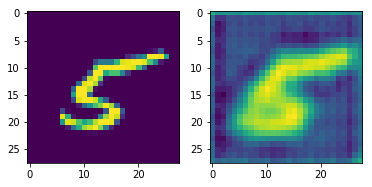

In [13]:
# Plot the input and output (i.e. reconstructed image)
idx = torch.randint(0, output.size(0), ())
pred = min_max_norm(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())


### Register hood to get network activations for a given input
We now need to register a forward hook on the model.

The hook will be called every time after forward() has computed an output. 
So the activation with the name specified will be saved after passing the data through the trained model.

You can register the hook in the following way:
```python
model.conv_name.register_forward_hook(get_activation('conv_name'))
```

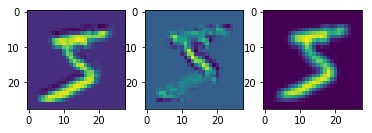

In [14]:
# Set up the hook for activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register the hook with the convolutional layer of interest
model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = model(data)

# Visualize the activation
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(1, act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


### Task 2: Visualise an activation of another convolutional layer
*Hint*: Look at the names for the layers when we first created our network

In [15]:
# --------------------------------------------- Task 2 --------------------------------------------------------
# write code here



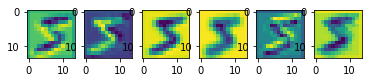

In [16]:
# Register the hook with the convolutional layer of interest
model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = model(data)

# Visualize the activation
act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(1, act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


## 3. CNN Layer Visualization

We will go through the next examples using code from the following repository https://github.com/utkuozbulak/pytorch-cnn-visualizations, which implements several well known visualization techniques for deep learning networks.

**CNN layer visualization** technique produces an image that minimizes the loss of a convolutional opteration for a specific layer and filter - i.e. it learns the image that optimally activates a particular convolutional filter.

**All the visualizations will be saved to /generated folder**

In [17]:
# load vgg model, and extract layers from the features modules only
pretrained_model = models.vgg16(pretrained=True).features


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/emma/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [01:06<00:00, 8.29MB/s] 


In [5]:
print(pretrained_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
cnn_layer = 21
filter_pos = 5
# Fully connected layer is not needed
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
#layer_vis.visualise_layer_without_hooks()


Iteration: 1 Loss: 1.00
Iteration: 2 Loss: 0.54
Iteration: 3 Loss: -4.17
Iteration: 4 Loss: -7.75
Iteration: 5 Loss: -11.51
Iteration: 6 Loss: -14.92
Iteration: 7 Loss: -18.13
Iteration: 8 Loss: -21.20
Iteration: 9 Loss: -24.12
Iteration: 10 Loss: -26.99
Iteration: 11 Loss: -29.80
Iteration: 12 Loss: -32.58
Iteration: 13 Loss: -35.36
Iteration: 14 Loss: -38.08
Iteration: 15 Loss: -40.78
Iteration: 16 Loss: -43.45
Iteration: 17 Loss: -46.11
Iteration: 18 Loss: -48.76
Iteration: 19 Loss: -51.40
Iteration: 20 Loss: -54.00
Iteration: 21 Loss: -56.60
Iteration: 22 Loss: -59.23
Iteration: 23 Loss: -61.84
Iteration: 24 Loss: -64.49
Iteration: 25 Loss: -67.15
Iteration: 26 Loss: -69.82
Iteration: 27 Loss: -72.54
Iteration: 28 Loss: -75.27
Iteration: 29 Loss: -78.05
Iteration: 30 Loss: -80.81


### Task 3: Visualize different CNN layers and filters
Change the CNN layer and filter to visualize the network at different depths

In [ ]:
# --------------------------------------------- Task 3 --------------------------------------------------------
# write code here



## 4. Gradient visualization with Guided backpropagation


In [3]:
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Guided backprop
GBP = GuidedBackprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')


Guided backprop completed


## 5. Grad CAM


In [5]:
# Get params
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)
# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')


Grad cam completed


## 6. Deep Dream


In [6]:
# THIS OPERATION IS MEMORY HUNGRY! #
# Because of the selected image is very large
# If it gives out of memory error or locks the computer
# Try it with a smaller image
cnn_layer = 34
filter_pos = 94

im_path = './visualizations/input_images/dd_tree.jpg'
# Fully connected layer is not needed

dd = DeepDream(pretrained_model, cnn_layer, filter_pos, im_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\cherb/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:42<00:00, 13.5MB/s]


Iteration: 1 Loss: 2.77
Iteration: 2 Loss: 0.61
Iteration: 3 Loss: -1.57
Iteration: 4 Loss: -5.64
Iteration: 5 Loss: -10.87
Iteration: 6 Loss: -14.60
Iteration: 7 Loss: -19.93
Iteration: 8 Loss: -22.96
Iteration: 9 Loss: -26.42
Iteration: 10 Loss: -36.34
(117, 224, 3)
Iteration: 11 Loss: -44.76
Iteration: 12 Loss: -48.59
Iteration: 13 Loss: -61.83
Iteration: 14 Loss: -68.44
Iteration: 15 Loss: -86.76
Iteration: 16 Loss: -99.98
Iteration: 17 Loss: -108.20
Iteration: 18 Loss: -120.65
Iteration: 19 Loss: -130.63
Iteration: 20 Loss: -140.53
(117, 224, 3)
Iteration: 21 Loss: -161.21
Iteration: 22 Loss: -171.47
Iteration: 23 Loss: -184.46
Iteration: 24 Loss: -197.56
Iteration: 25 Loss: -205.05
Iteration: 26 Loss: -230.14
Iteration: 27 Loss: -250.46
Iteration: 28 Loss: -269.46
Iteration: 29 Loss: -280.43
Iteration: 30 Loss: -294.50
(117, 224, 3)
Iteration: 31 Loss: -307.95
Iteration: 32 Loss: -325.44
Iteration: 33 Loss: -340.58
Iteration: 34 Loss: -361.21
Iteration: 35 Loss: -379.82
Iteration